In [1]:
import sys
sys.path.insert(0, '../gambit')

import os
import sep
import numpy as np
import itertools
from scipy import ndimage
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from gambit import create_diff_per_image, clean_data, create_diff_image, normalize_array
from mask import create_segmentation_masks, create_ellipse_mask_from_sep_object, create_bisection_mask
from fits import read_fits, view_fits, write_fits
from spin_parity import read_spin_parity_galaxies_label_from_csv
from matrix import *
from visualize import construct_diff_plot

np.seterr('raise')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [2]:
#DON'T change this:
bands_in_order = ['g','r','i','z','y']

PANSTARRS_COLOR_DICT = {'g':'green',
                        'r':'red',
                        'i':'indigo',
                        'z':'blue',
                        'y':'orange'}

In [3]:
#Change this:
#path_to_input = "/Users/cora-at-work/Desktop/github/spin-parity-catalog/original/galaxies/"
#csv_path = "/Users/cora-at-work/Desktop/github/spin-parity-catalog/table_info/csv_format_of_table/"
path_to_input = "C:\\Users\\school\\Desktop\\github\\spin-parity-catalog\\original\\galaxies\\"
csv_path = "C:\\Users\\school\\Desktop\\github\\spin-parity-catalog\\table_info\\csv_format_of_table\\"
path_to_github_dir = "C:\\Users\\school\\Desktop\\github"

In [4]:
 #Update these as needed:
table_key = "table3"

In [5]:
def get_galaxy_list():
    return os.listdir(os.path.join(path_to_input,table_key))

def fits_path(name,band):
    return os.path.join(path_to_input,table_key,name,"{}_{}.fits".format(name,band))

def get_csv_path():
    return os.path.join(csv_path,"table_{}.csv".format(table_key.strip()[-1]))

def color_image_path(name):
    return os.path.join(path_to_github_dir,'spin-parity-catalog/{}/galaxies/{}/{}/{}_color.jfif'.format('original',table_key,name,name))

In [6]:
class gal:
    def __init__(self,name,dark_side):
        self.name = name
        self.dark_side = dark_side
        self.data = dict()
        self.el_seps = dict()
        
    def can_make_el_for_band(self,band):
        if band in self.el_seps and band in self.data:
            #return 'x' in self.el_seps[band] and 'y' in self.el_seps[band] and 'a' in self.el_seps[band] and 'b' in self.el_seps[band] and 'theta' in self.el_seps[band]
            return True
        return False
    
    def make_pos_neg_el_masks(self,band,r=1.0):
        band = 'i'
        #print(np.degrees(self.el_seps[band]['theta']))
        #el = create_ellipse_mask(self.el_seps[band]['x'],self.el_seps[band]['y'],self.el_seps[band]['a'],self.el_seps[band]['b'],self.el_seps[band]['theta'],r=1.0,shape=self.data[band].shape)
        el = create_ellipse_mask_from_sep_object(self.el_seps[band],shape=self.data[band].shape,r=1.0)
        pos,neg = create_bisection_mask(self.el_seps[band]['x'],self.el_seps[band]['y'],self.el_seps[band]['theta'],self.data[band].shape)
        return pos, neg,  el
    
    def create_valid_mask(self,band):
        return np.logical_not(np.logical_or(np.isnan(self.data[band]),np.isinf(self.data[band])))
    
    def get_normalized_data(self,band,area_to_norm,use_sigmoid=True):
        valid_mask = self.create_valid_mask(band)
        foreground=np.logical_and(valid_mask,area_to_norm)
        data = self.data[band]
        to_return = np.zeros(data.shape)
        
        if use_sigmoid:
            alpha = np.max(data[foreground])-np.min(data[foreground]) #https://en.wikipedia.org/wiki/Normalization_(image_processing)
            beta = alpha/2 + np.min(data[foreground])
            data-=beta
            data*=(1/alpha)
            data=( 1/(1 + np.exp(-data)))
            
            to_return[foreground] = data[foreground]
        else:
            to_return[foreground] = normalize_array(data,foreground)[foreground]
        return to_return, valid_mask
    
    def get_pos_neg_labels(self,band):
        band = 'i'
        return pos_neg_label_from_theta(np.degrees(self.el_seps[band]['theta'])) #pos, neg
    
def load_gal(name,dark_side=''):
    the_gal = gal(name,dark_side)
    for band in bands_in_order:
        the_fits_path = fits_path(name,band)
        if not (os.path.exists(the_fits_path)): continue
        the_gal.data[band] = read_fits(the_fits_path)
        
        the_mask = np.logical_or(np.isnan(the_gal.data[band]), np.isinf(the_gal.data[band]))
        #view_fits(the_mask2)
        #the_mask = None
        
        (foreground,_) = create_segmentation_masks(the_gal.data[band],mask=the_mask)
        if np.sum(foreground) <= 0.01*np.sum(the_gal.data[band].shape): continue
        #cm_y, cm_x = calculate_center_of_mass(foreground)
        cm_x, cm_y = calculate_center_of_mass(foreground)
    
        
        the_el_sep = run_sep(the_gal.data[band], cm_x, cm_y)
        
        if the_el_sep is None: continue
        the_gal.el_seps[band] = the_el_sep
    return the_gal

In [7]:
def calculate_center_of_mass(the_mask):
    cm = ndimage.center_of_mass(the_mask)
    return (cm[-1],cm[0])

#sep object:
def calc_dist(cm_x,cm_y,el_x,el_y):
    return (((cm_x-el_x)*(cm_x-el_x)) + ((cm_y-el_y)*(cm_y-el_y)))**0.5

def calc_sep_size(a,b):
    return 3.14*a*b

def run_sep(data, cm_x, cm_y):
    data = data.byteswap().newbyteorder()
    bkg = sep.Background(data)
    data_sub = data - bkg
    
    objects = sep.extract(data_sub, 1.5, err=bkg.globalrms)
    
    the_el_sep = None
    the_el_sep_dist = np.inf
    
    #return
    
    for i in objects:
        if calc_sep_size(i['a'],i['b']) < 0.001*data.shape[0]*data.shape[1]: continue
        
        d = calc_dist(cm_x,cm_y,i['x'],i['y'])
        if d < the_el_sep_dist:
            the_el_sep = i; the_el_sep_dist = d
            
    if the_el_sep != None:
        the_el = create_ellipse_mask_from_sep_object(the_el_sep,data.shape,r=2)
        return the_el_sep
    return None

In [8]:
def classify_pos_neg(ys,the_min=0.01):
    the_biggest = ys[np.argmax(np.abs(ys))]
    if np.abs(the_biggest) >= the_min:
        return -1.0*np.sign(the_biggest)
    else:
        return 0.0
    
def get_opposite(label):
    labels = ['n','ne','e','se','s','sw','w','nw']
    opposite_labels = ['s','sw','w','nw','n','ne','e','se']
    
    if label.strip().lower() in labels:
        return opposite_labels[labels.index(label.strip().lower())]
    return ""

def pos_neg_label_from_theta(theta):
    new_theta = theta % 360
    pos = '-'
    neg = '-'
    if new_theta <= 22.5:
        pos = 'n'
        neg = 's'
    elif new_theta > 22.5 and new_theta < 67.5:
        pos = 'ne'
        neg = 'sw'
    elif new_theta >= 67.5 and new_theta <= 112.5:
        pos = 'e'
        neg = 'w'
    elif new_theta > 112.5 and new_theta < 157.5:
        pos = 'se'
        neg = 'nw'
    elif new_theta >= 157.5 and new_theta <= 202.5:
        pos = 's'
        neg = 'n'
    elif new_theta > 202.5 and new_theta < 247.5:
        pos = 'sw'
        neg = 'ne'
    elif new_theta >= 247.5 and new_theta <= 292.5:
        pos = 'w'
        neg = 'e'
    elif new_theta > 292.5 and new_theta < 337.5:
        pos = 'nw'
        neg = 'se'
    else:
        pos = 'n'
        neg = 's'
    return pos.upper(),neg.upper()

In [9]:
DEFAULT_POSITIVE_RGB_VECTOR = [60/255,179/255,113/255] #mediumseagreen
DEFAULT_NEGATIVE_RGB_VECTOR = [240/255,128/255,125/255] #lightcoral
DEFAULT_BAD_PIXEL_RGB_VECTOR = [169/255,169/255,169/255] #lightgrey

def create_color_map_class(pos,neg,valid_pixels):
    cmap_class = np.zeros((pos.shape[0],pos.shape[1],3))
    
    cmap_class[pos>=1.0] = DEFAULT_POSITIVE_RGB_VECTOR
    cmap_class[neg>=1.0] = DEFAULT_NEGATIVE_RGB_VECTOR
    cmap_class[valid_pixels<1.0] = DEFAULT_BAD_PIXEL_RGB_VECTOR
    
    return cmap_class


def create_diff_fig(the_gal,xs_dict,ys_dict, classify_dict, score_dict, dark_side, vis_path=''):
    gs_kw = dict(width_ratios=[1,1,1], height_ratios=[1, 1, 2])
    fig, axd = plt.subplot_mosaic([['color','g','r'],
                                   ['i','z','y'],
                                   ['diff','diff','diff']],
                                  gridspec_kw=gs_kw, figsize = (24,32),
                                  constrained_layout=True,num=1, clear=True) #num=1, clear=True #https://stackoverflow.com/a/65910539/13544635
    fig.patch.set_facecolor('white')
    
    color_image = mpimg.imread(color_image_path(the_gal.name))
    axd['color'].imshow(color_image)
    axd['color'].set_title("{}: dark side {}".format(the_gal.name,dark_side))
    
    for band in xs_dict:
        pos, neg,  el = the_gal.make_pos_neg_el_masks(band,r=1.0)
        cmap = create_color_map_class(np.logical_and(pos,el), np.logical_and(neg,el), np.ones(pos.shape))
        
        data = the_gal.data[band]
        valid = the_gal.create_valid_mask(band)
        m, s = np.mean(data[valid]), np.std(data[valid])
        axd[band].imshow(data, interpolation='nearest', cmap='gray', vmin=m-3*s, vmax=m+3*s, origin='lower') #, cmap='gray'
        axd[band].imshow(cmap, origin= 'lower',alpha=0.4)
        """
        found=""
        pos,neg=the_gal.get_pos_neg_labels(band)
        if classify_dict[band] == 1.0:
            found = pos
        elif classify_dict[band] == -1.0:
            found = neg
        """
        
        band_title = '{} dark side: {} ({})'.format(band,classify_dict[band], score_dict[band])
        axd[band].set_title(band_title, color=PANSTARRS_COLOR_DICT[band])
        
        axd['diff'].plot(xs_dict[band],ys_dict[band],c=PANSTARRS_COLOR_DICT[band],label=band_title)
        axd['diff'].legend()
    if vis_path != "":
        fig.savefig(vis_path, dpi = 300, bbox_inches='tight')
    else:
        plt.show()

In [10]:
def construct_single_band_norm_comparison(the_gal,dark_side,vis_path='',use_sigmoid=True,steps=17):
    #print('h1')
    if 'i' not in the_gal.data or 'y' not in the_gal.el_seps: return
    xs_dict = dict(); ys_dict = dict(); classify_dict = dict(); score_dict = dict()
    for band in the_gal.data:
        xs = []; ys = []
        if the_gal.can_make_el_for_band(band):
            pos, neg,  el = the_gal.make_pos_neg_el_masks(band,r=1.0)
            normed, valid_mask = the_gal.get_normalized_data(band,el,use_sigmoid)
            
            to_consider = np.logical_and(el,valid_mask)
            pos_el = np.logical_and(pos,to_consider)
            neg_el = np.logical_and(neg,to_consider)
            
            for x in np.linspace(np.min(normed[to_consider]),np.max(normed[to_consider]),steps):
                pos_side = np.sum(normed[pos_el] >= x)/np.sum(pos_el)
                neg_side = np.sum(normed[neg_el] >= x)/np.sum(neg_el)
                xs.append(x); ys.append(pos_side-neg_side)
            xs_dict[band] = xs
            ys_dict[band] = ys
            
            pos,neg=the_gal.get_pos_neg_labels(band) #(pos,neg)
            side = classify_pos_neg(ys,the_min=0.01) #-1, 0, 1
            label=""
            opposite=""
            if side == 1.0:
                label=pos
                opposite=neg
            elif side == -1.0:
                label=neg
                opposite=pos
            
            score = 0
            correct_label_letter_count = len(set([*label.lower()]).intersection([*dark_side.lower()])) #fixed bug (used to be union)
            incorrect_label_letter_count = len(set([*opposite.lower()]).intersection([*dark_side.lower()])) #fixed bug (used to be union)
            
            #print(correct_label_letter_count)
            #print(incorrect_label_letter_count)
        
            if correct_label_letter_count > incorrect_label_letter_count and correct_label_letter_count >= 1:
                score_dict[band] = 1
            elif incorrect_label_letter_count > correct_label_letter_count and incorrect_label_letter_count >= 1:
                score_dict[band] = -1
            else:
                score_dict[band] = 0
        
            classify_dict[band] = label

    create_diff_fig(the_gal,xs_dict,ys_dict, classify_dict, score_dict, dark_side, vis_path)
    return score_dict

In [11]:
def construct_single_band_norm_sides_seperately_comparison(the_gal,dark_side,vis_path='',use_sigmoid=True,steps=17):
    #print('h')
    if 'i' not in the_gal.data or 'y' not in the_gal.el_seps: return
    xs_dict = dict(); ys_dict = dict(); classify_dict = dict(); score_dict = dict()
    for band in the_gal.data:
        xs = []; ys = []
        if the_gal.can_make_el_for_band(band):
            pos, neg,  el = the_gal.make_pos_neg_el_masks(band,r=1.0)
            normed = np.zeros(the_gal.data[band].shape)
            
            normedp, valid_mask = the_gal.get_normalized_data(band,np.logical_and(pos,el),use_sigmoid)
            normedn, _ = the_gal.get_normalized_data(band,np.logical_and(neg,el),use_sigmoid)
            
            normed[pos] = normedp[pos]
            normed[neg] = normedn[neg]
            
            #view_fits(normed)
            
            to_consider = np.logical_and(el,valid_mask)
            pos_el = np.logical_and(pos,to_consider)
            neg_el = np.logical_and(neg,to_consider)
            
            for x in np.linspace(np.min(normed[to_consider]),np.max(normed[to_consider]),steps):
                pos_side = np.sum(normed[pos_el] >= x)/np.sum(pos_el)
                neg_side = np.sum(normed[neg_el] >= x)/np.sum(neg_el)
                xs.append(x); ys.append(pos_side-neg_side)
            xs_dict[band] = xs
            ys_dict[band] = ys
            
            pos,neg=the_gal.get_pos_neg_labels(band) #(pos,neg)
            #print(pos,neg)
            side = classify_pos_neg(ys,the_min=0.01) #-1, 0, 1
            #print(side)
            label=""
            opposite=""
            if side == 1.0:
                label=pos
                opposite=neg
            elif side == -1.0:
                label=neg
                opposite=pos
            
            score = 0
            correct_label_letter_count = len(set([*label.lower()]).intersection([*dark_side.lower()])) #fixed bug (used to be union)
            incorrect_label_letter_count = len(set([*opposite.lower()]).intersection([*dark_side.lower()])) #fixed bug (used to be union)
            
            #print(correct_label_letter_count)
            #print(incorrect_label_letter_count)
        
            if correct_label_letter_count > incorrect_label_letter_count and correct_label_letter_count >= 1:
                score_dict[band] = 1
            elif incorrect_label_letter_count > correct_label_letter_count and incorrect_label_letter_count >= 1:
                score_dict[band] = -1
            else:
                score_dict[band] = 0
        
            classify_dict[band] = label
            
            #print(score_dict[band])

    create_diff_fig(the_gal,xs_dict,ys_dict, classify_dict, score_dict, dark_side, vis_path)
    return score_dict

CSV_OUTPUT_ROW = ['name','dark']
CSV_OUTPUT_ROW.extend(bands_in_order)

def get_csv_row(name,dark_side,score_dict):
    the_row = [name,dark_side]
    for band in bands_in_order:
        if band in score_dict:
            the_row.append(score_dict[band])
        else:
            the_row.append(0)
    return the_row

In [12]:
import csv
def write_csv(csv_path,csv_col,csv_rows):
    to_write = [csv_col]
    to_write.extend(csv_rows)

    with open(csv_path, 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerows(to_write)

In [13]:
#todo: 
# 1) Output csv for current version and check right/ wrong percent
# 1.5) Compare seperate norm and together norm and with prior results
# 2) Band pair diff with each side normalized seperately

1 IC1151 nw
2 IC1199 ne
3 IC1256 n
4 IC1528 se
5 IC2095 se
error
5 IC2163 s
6 IC2487 ne
7 IC467 se
8 IC5309 se
9 IC674 sw
10 IC776 sw
error
10 IRAS03056+2034 ne
11 NGC1 nw
12 NGC1012 se
13 NGC1042 s
error
13 NGC1058 nw
14 NGC1068 w
15 NGC1073 sw
16 NGC1087 nw
17 NGC1169 nw
18 NGC1300 n
error
18 NGC1358 ne
19 NGC160 se
20 NGC1614 w
21 NGC1645 s
22 NGC1677 sw
23 NGC171 n
24 NGC1744 e
error
24 NGC177 nw
25 NGC1784 n
26 NGC180 nw
27 NGC1832 se
28 NGC192 nw
29 NGC2139 ne
30 NGC214 nw
31 NGC217 ne
32 NGC2207 n
33 NGC2276 s
34 NGC23 se
35 NGC2336 w
36 NGC234 nw
37 NGC237 e
38 NGC2449 sw
39 NGC2486 n
40 NGC2487 sw
41 NGC2500 nw
42 NGC2525 s
43 NGC2540 ne
44 NGC2552 nw
error
44 NGC257 n
45 NGC2604 sw
46 NGC2608 se
47 NGC2730 se
48 NGC2776 sw
49 NGC278 se
50 NGC2805 sw
error
50 NGC289 ne
51 NGC2906 nw
52 NGC2916 nw
53 NGC2964 n
54 NGC2998 nw
55 NGC3057 se
error
55 NGC3106 ne
56 NGC3145 nw
57 NGC3166 nw
58 NGC3206 w
59 NGC3319 se
error
59 NGC3433 nw
60 NGC3504 e
61 NGC36 ne
62 NGC3614 ne
63 NGC36

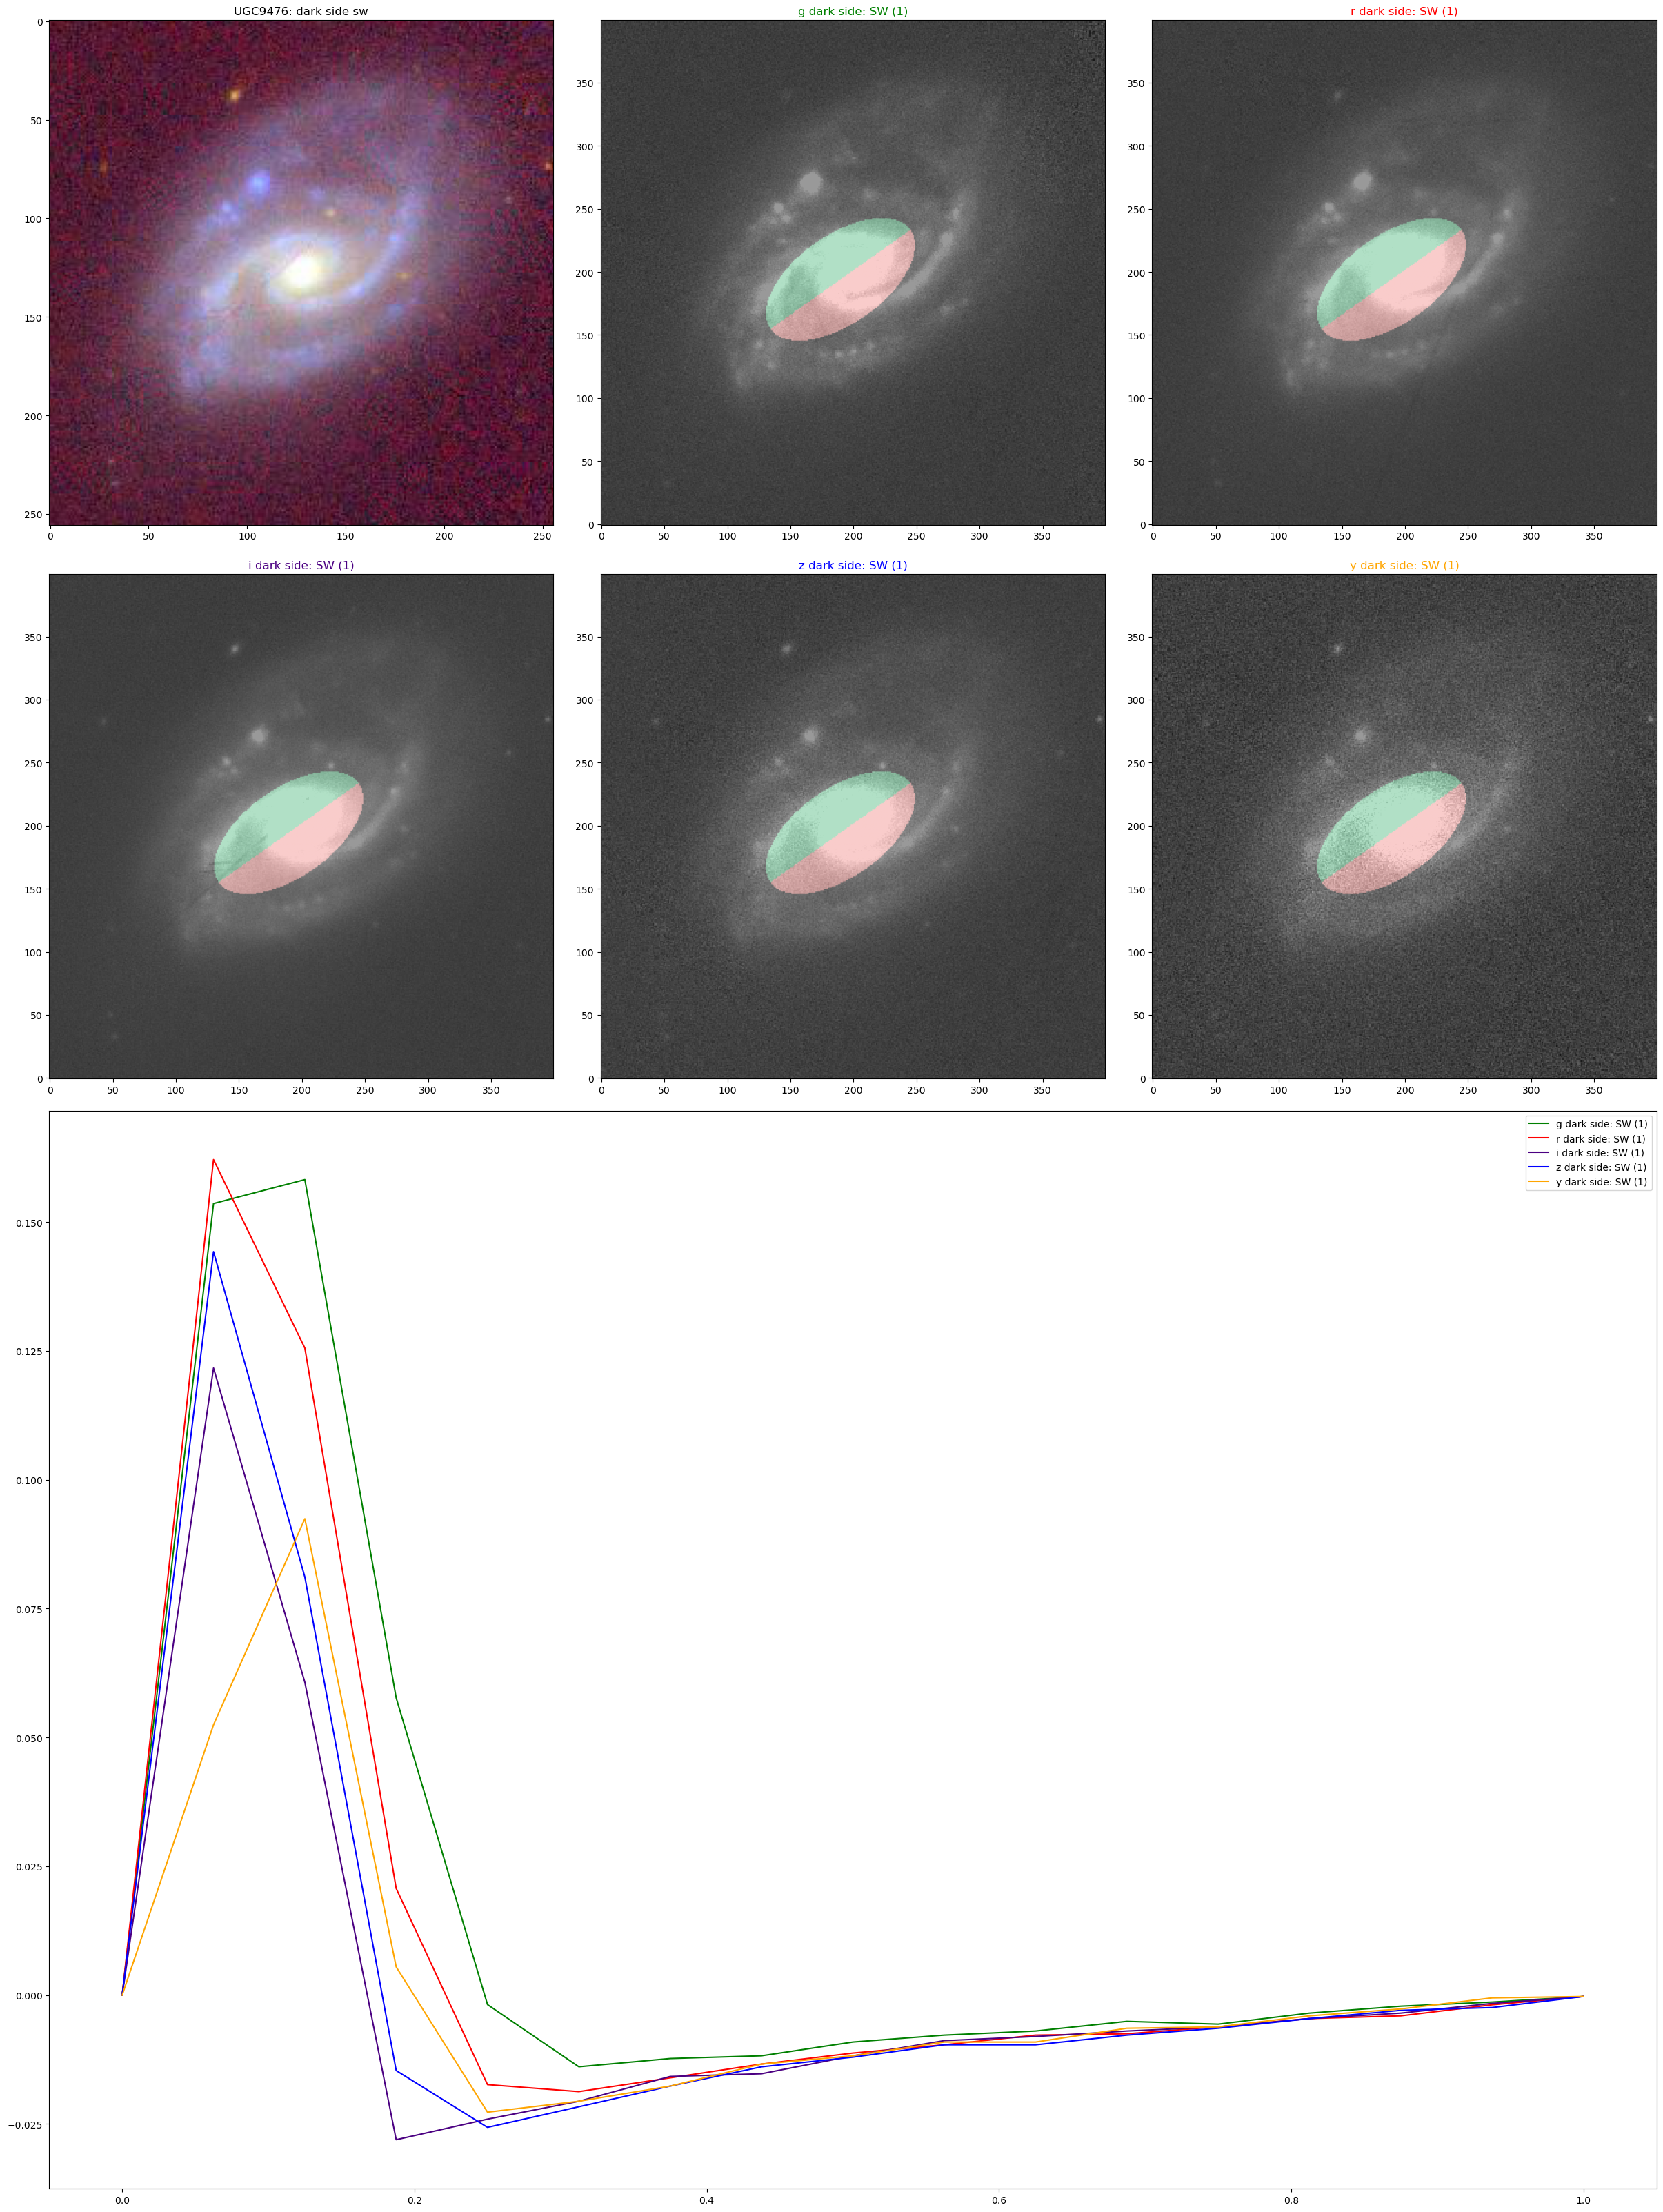

In [14]:
i = 1
dark_side = read_spin_parity_galaxies_label_from_csv(get_csv_path())
gals = get_galaxy_list()
#gals = ['NGC3495']
#gals = ['IC1683']

csv_rows = []


use_seperate = False
to_write_csv = True
save_vis = True

if use_seperate:
    vis_output_p_path = "C:\\Users\\school\\Desktop\\03_17_2023_research"
else:
    vis_output_p_path = "C:\\Users\\school\\Desktop\\03_17_2023_research_not_seperate"


for name in gals:
    if name not in dark_side: continue
    print(i,name, dark_side[name])
    xs_dict = dict(); ys_dict = dict()
    
    #construct_single_band_norm_comparison(the_gal,True)
    #construct_single_band_norm_comparison(the_gal,False)
    #construct_single_band_norm_sides_seperatelycomparison(the_gal,True)
    pa = ''
    
    try:
        the_gal = load_gal(name,dark_side[name])
        if save_vis:
            pa = os.path.join(vis_output_p_path,table_key,"{}.png".format(name))
        if use_seperate:
            score_dict = construct_single_band_norm_sides_seperately_comparison(the_gal,dark_side[name],pa,False)
        else:
            score_dict = construct_single_band_norm_comparison(the_gal,dark_side[name],pa,False)
        csv_rows.append(get_csv_row(name,dark_side[name],score_dict))
        i += 1
    except:
        print('error')
    #break
#print(csv_rows)

if to_write_csv:
    csv_out_path = os.path.join(vis_output_p_path,"{}.csv".format(table_key))
    write_csv(csv_out_path,CSV_OUTPUT_ROW,csv_rows)